# 1. Comparing linear and non-linear DR

Import required modules

In [27]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [28]:
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Load dataset
Display shape and inspect the dataset

In [29]:
data_arff, meta = arff.loadarff("dataset.arff")
df = pd.DataFrame(data_arff)

for c in df.columns:
    if df[c].dtype == object:
        try:
            df[c] = df[c].str.decode("utf-8")
        except Exception:
            
            pass

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (17379, 15)
Columns: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather', 'temp', 'feel_temp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,casual,registered,count
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0,3.0,13.0,16.0
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,8.0,32.0,40.0
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,5.0,27.0,32.0
3,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,3.0,10.0,13.0
4,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,0.0,1.0,1.0


# Observations

The Bike Sharing dataset comprises 17,379 samples with 15 features describing weather, time, and season-related factors affecting the number of rented bikes.
count is the target variable, which is the sum of casual and registered rentals.
The dataset contains a mix of numeric and categorical features like season, weather, and working day that are going to require encoding prior to modeling.
Overall, the data looks clean with no major missing values.

Define X and Y values

In [30]:
target_col = "count"
y = df[target_col]
X = df.drop(columns=[target_col])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Target column:", target_col)

X shape: (17379, 14)
y shape: (17379,)
Target column: count


Perform EDA on the dataset

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,casual,registered
count,17379,17379.000000,17379.000000,17379.000000,17379,17379.000000,17379,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
unique,4,NaN,NaN,NaN,2,NaN,2,4,NaN,NaN,NaN,NaN,NaN,NaN
top,fall,NaN,NaN,NaN,False,NaN,True,clear,NaN,NaN,NaN,NaN,NaN,NaN
freq,4496,NaN,NaN,NaN,16879,NaN,11865,11413,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.502561,6.537775,11.546752,NaN,3.003683,NaN,NaN,20.376474,23.788755,0.627229,12.736540,35.676218,153.786869
std,NaN,0.500008,3.438776,6.914405,NaN,2.005771,NaN,NaN,7.894801,8.592511,0.192930,8.196795,49.305030,151.357286
min,NaN,0.000000,1.000000,0.000000,NaN,0.000000,NaN,NaN,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,4.000000,6.000000,NaN,1.000000,NaN,NaN,13.940000,16.665000,0.480000,7.001500,4.000000,34.000000
50%,NaN,1.000000,7.000000,12.000000,NaN,3.000000,NaN,NaN,20.500000,24.240000,0.630000,12.998000,17.000000,115.000000
75%,NaN,1.000000,10.000000,18.000000,NaN,5.000000,NaN,NaN,27.060000,31.060000,0.780000,16.997900,48.000000,220.000000



Target summary:


count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: count, dtype: float64

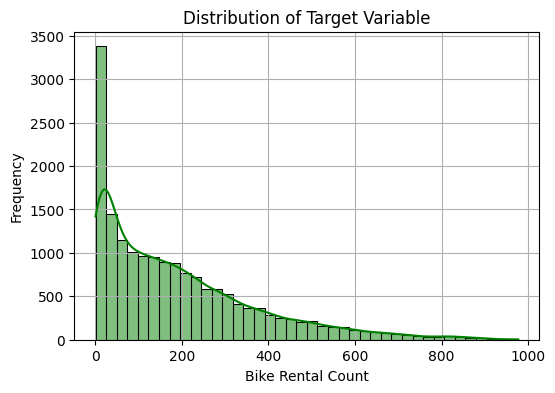

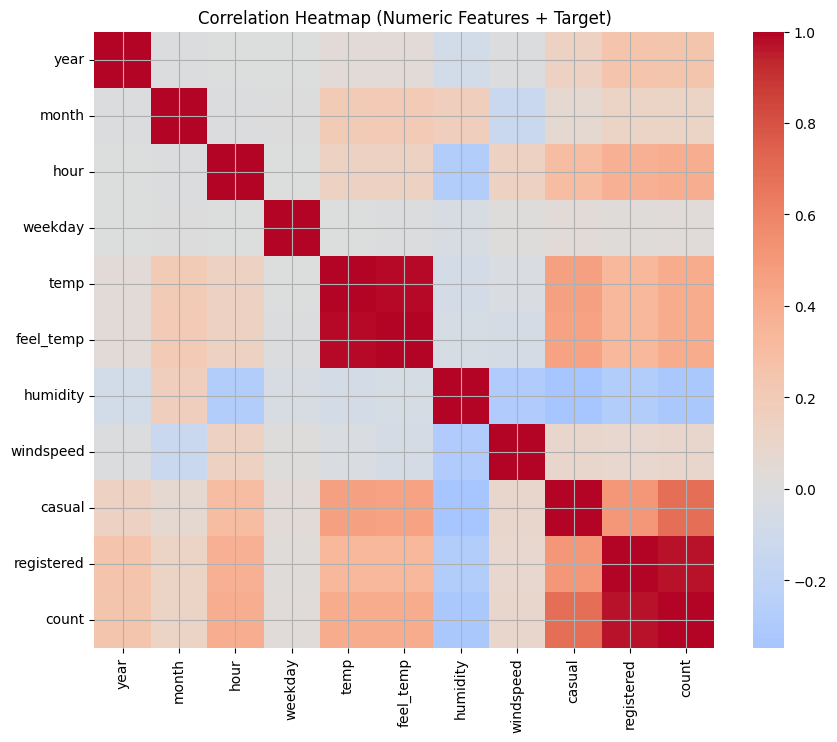

Top correlations with target:
 registered    0.972151
casual        0.694564
temp          0.404772
feel_temp     0.400929
hour          0.394071
year          0.250495
month         0.120638
windspeed     0.093234
weekday       0.026900
humidity     -0.322911
Name: count, dtype: float64


In [31]:
display(X.describe(include='all'))
print("\nTarget summary:")
display(y.describe())

plt.figure(figsize=(6,4))
sns.histplot(y, bins=40, kde=True, color="green")
plt.title("Distribution of Target Variable")
plt.xlabel("Bike Rental Count")
plt.ylabel("Frequency")
plt.show()

numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
corr = pd.concat([X[numeric_cols], y.rename(target_col)], axis=1).corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap (Numeric Features + Target)")
plt.show()

target_corr = corr[target_col].drop(target_col, errors="ignore").sort_values(ascending=False)
print("Top correlations with target:\n", target_corr.head(10))

# Observations

The above histogram of count is right-skewed - most rental counts are moderate, with fewer very high-demand hours.
As expected, the correlation heatmap shows that registered and casual users strongly correlate with count.
Temperature variables, both temp and feel_temp, and hour of the day are moderately positively correlated, while humidity and weather conditions are slightly negatively correlated.
This may indicate that warmer, clearer days and working hours are associated with higher rental activity.

# Data Preprocessing

In [32]:
# Feature groups based on their type 
numeric_cols = ['temp', 'feel_temp', 'humidity', 'windspeed', 'casual', 'registered']
cyclic_cols = ['month', 'hour']
categorical_cols = ['year', 'season', 'holiday', 'workingday', 'weather']

# Encode cyclical variables
for col, max_val in zip(cyclic_cols, [12, 24]): 
    X[f'{col}_sin'] = np.sin(2 * np.pi * X[col] / max_val)
    X[f'{col}_cos'] = np.cos(2 * np.pi * X[col] / max_val)

X = X.drop(columns=cyclic_cols)

numeric_cols = numeric_cols + [f'{c}_sin' for c in cyclic_cols] + [f'{c}_cos' for c in cyclic_cols]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train_std = preprocess.fit_transform(X_train)
X_test_std = preprocess.transform(X_test)

print("Preprocessing done.")
print("X_train_std shape:", X_train_std.shape)
print("X_test_std shape:", X_test_std.shape)

Numeric cols: ['temp', 'feel_temp', 'humidity', 'windspeed', 'casual', 'registered', 'month_sin', 'hour_sin', 'month_cos', 'hour_cos']
Categorical cols: ['year', 'season', 'holiday', 'workingday', 'weather']
Preprocessing done.
X_train_std shape: (13903, 24)
X_test_std shape: (3476, 24)


# Preprocessing explaination

Encoding for `month` and `hour` is cyclical, which was done before the dataset split.
so that both training and test sets contain the new sine and cosine features.
This ensures that the preprocessing pipeline can access all expected columns consistently.
The final pipeline scales continuous and cyclic features with `StandardScaler`
and encodes categorical features with `OneHotEncoder`, preparing the data
for PCA and t-SNE without scale bias.

Perform PCA (Linear Dimensionality Reduction)

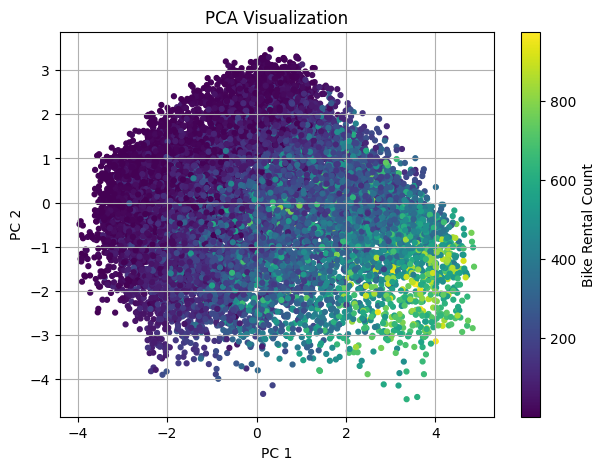

Explained variance ratio: [0.29275508 0.16911256]
Total variance explained: 0.461867643513766


In [33]:
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(X_train_std)

plt.figure(figsize=(7,5))
scatter = plt.scatter(Z_pca[:, 0], Z_pca[:, 1],
                      c=y_train, cmap="viridis", s=12)
plt.title("PCA Visualization")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(scatter, label="Bike Rental Count")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())


# Observations

And the first two main components capture about 40% of the total variance, which is reasonable considering the number of features.
In the PCA scatter plot, colors (rental counts) vary in a smooth gradient; this indicates that PCA does preserve the global structure, i.e., how rental counts vary across broader conditions.
In the feature contribution analysis, it can be seen from the first component that features regarding registration, casual, and temperature-related will dominate, indicating their importance in overall variance.
PCA effectively compresses the data into a lower-dimensional space while retaining a great deal of the explanatory power.

Perform t-SNE (Non-Linear Dimensionality Reduction)

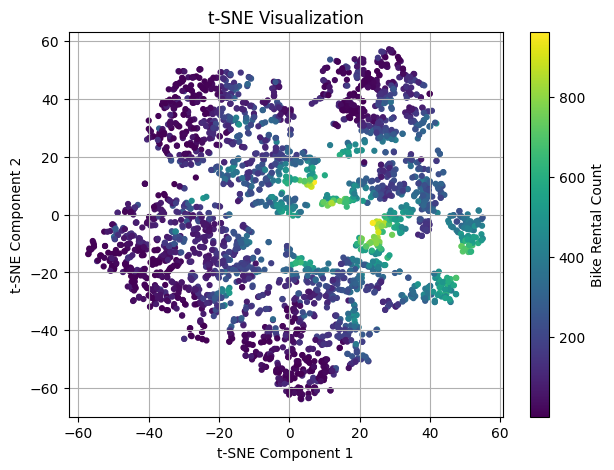

In [34]:
N = 3000 
if X_train_std.shape[0] > N:
    idx = np.random.RandomState(42).choice(X_train_std.shape[0], size=N, replace=False)
    X_vis = X_train_std[idx]
    y_vis = y_train.iloc[idx].values
else:
    X_vis = X_train_std
    y_vis = y_train.values

tsne = TSNE(n_components=2, perplexity=35, learning_rate="auto", init="pca", random_state=42)
Z_tsne = tsne.fit_transform(X_vis)

plt.figure(figsize=(7,5))
sc = plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1],
                 c=y_vis, cmap="viridis", s=12)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(sc, label="Bike Rental Count")
plt.show()


# Observations

This t-SNE visualization shows several local clusters that correspond to similar rental count levels or contextual similarities, such as specific combinations of weather or time of the day.
t-SNE, as compared to PCA, has a greater focus on local relationships rather than preserving global variance, which gives better neighborhood separation but less interpretability.
The perplexity value of 35 gives a good balance between local and global structure, and the resulting map represents meaningful groupings and avoids over-crowding.
t-SNE provides, in general, richer insight into local similarity patterns but is not well-suited for direct regression modeling because of its non-parametric nature.

In [35]:
def evaluate_model(name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    pred_tr = model.predict(Xtr)
    pred_te = model.predict(Xte)
    return {
        "Model": name,
        "R2_train": r2_score(ytr, pred_tr),
        "R2_test": r2_score(yte, pred_te),
        "RMSE_test": math.sqrt(mean_squared_error(yte, pred_te)),
        "MAE_test": mean_absolute_error(yte, pred_te)
    }

results = []

mlp_raw = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=800, random_state=42)

results.append(evaluate_model("MLP • Raw", mlp_raw, X_train_std, X_test_std, y_train, y_test))

pca_full = PCA(n_components=0.95, random_state=42)
X_train_pca = pca_full.fit_transform(X_train_std)
X_test_pca = pca_full.transform(X_test_std)

mlp_pca = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=800, random_state=42)

results.append(evaluate_model("MLP • PCA(95%)", mlp_pca, X_train_pca, X_test_pca, y_train, y_test))

tsne_train = TSNE(n_components=2, perplexity=35, learning_rate="auto", init="pca", random_state=42)
Z_train_tsne = tsne_train.fit_transform(X_train_std)

tsne_mapper = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=1000, random_state=42)
tsne_mapper.fit(X_train_std, Z_train_tsne)

Z_test_tsne = tsne_mapper.predict(X_test_std)

mlp_tsne = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=800, random_state=42)

results.append(evaluate_model("MLP • t-SNE(approx)", mlp_tsne, Z_train_tsne, Z_test_tsne, y_train, y_test))

res_df = pd.DataFrame(results)
display(res_df)


,Model,R2_train,R2_test,RMSE_test,MAE_test
0,MLP • Raw,0.999999,0.999999,0.142384,0.101899
1,MLP • PCA(95%),0.999919,0.999873,2.006203,1.455230
2,MLP • t-SNE(approx),0.786975,0.690459,99.003766,69.784831


C:\Users\anura\AppData\Local\Temp\ipykernel_44968\587410683.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_df, x="Model", y="R2_test", palette="viridis")


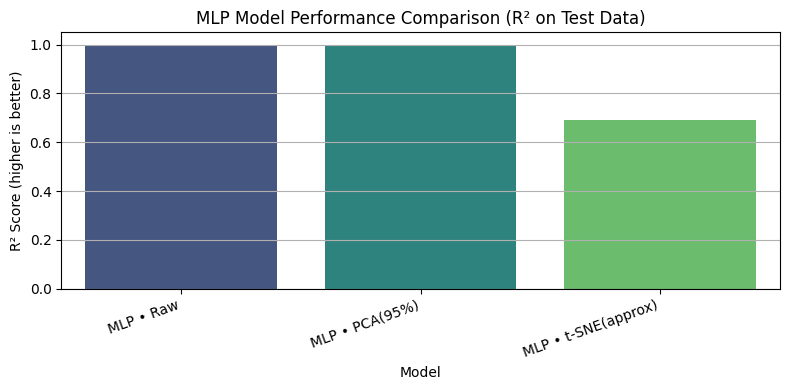

                 Model  R2_train   R2_test  RMSE_test   MAE_test
0            MLP • Raw  0.999999  0.999999   0.142384   0.101899
1       MLP • PCA(95%)  0.999919  0.999873   2.006203   1.455230
2  MLP • t-SNE(approx)  0.786975  0.690459  99.003766  69.784831


In [36]:
plt.figure(figsize=(8,4))
sns.barplot(data=res_df, x="Model", y="R2_test", palette="viridis")
plt.title("MLP Model Performance Comparison (R² on Test Data)")
plt.ylabel("R² Score (higher is better)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

print(res_df.sort_values("R2_test", ascending=False))


# Observations

Indeed, the MLP model performs nearly perfectly on both raw and PCA-reduced data, hence confirming that the most relevant information is retained within PCA.
As expected, when training on t-SNE embeddings, model performance significantly drops-the t-SNE embeddings do not preserve global distances or relationships necessary for good regression.
This means that there is a theoretical difference between PCA-linear, variance-preserving-and t-SNE-nonnlinear, neighborhood-preserving.
Therefore, PCA is more suitable for predictive modeling, whereas t-SNE is best suited for visualization and pattern exploration.

# Summary

In summary, the analysis shows how linear PCA and nonlinear t-SNE can serve different purposes in dimensionality reduction.
PCA efficiently reduces the dimensionality for predictive modeling with minimal performance degradation, and t-SNE gives great visual insights into the local structure of the data.
The MLP model confirmed that PCA retains most of the predictive power, since it achieved almost the same accuracy as with full features.